In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39591/status,
Dashboard: /proxy/39591/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43935,Workers: 4
Dashboard: /proxy/39591/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:43931,Total threads: 4
Dashboard: /proxy/33141/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:46281,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [4]:
def figure2():
    plt.rcParams['font.size'] = 14
    fig = plt.figure(figsize = (18, 10))
    gr = gs.GridSpec(2, 2, figure = fig, width_ratios = [1, .03], 
                     hspace = .05, wspace = 0.05)
    axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]),
           fig.add_subplot(gr[:,1])]
    for ax, label in zip(axs, ['(a)', '(b)']):
        ax.text(-0.1, .93, label, transform = ax.transAxes, size = 20, weight = 'bold')
        ax.set_xlim([-180, 179.25])
        ax.set_ylim([-80, -59.5])
        ax.set_yticks(np.arange(-77.5, -60, 2.5))
        ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', 
                            '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', 
                            '62.5$^{\circ}$S'])
        if ax in [axs[0]]:
            ax.set_xticklabels([])
        else:
            ax.set_xticks(np.arange(-150, 200, 50))
            ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', 
                                '0$^{\circ}$E',  '50$^{\circ}$E', '100$^{\circ}$E', 
                                '150$^{\circ}$E'])
        # Land
        ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                    colors = 'darkgrey', linewidths = 0.5, 
                    zorder = 2)
        ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
    return fig, axs

def figure4():
    plt.rcParams['font.size'] = 14
    fig = plt.figure(figsize = (18, 20))
    gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.03], 
                     hspace = .06, wspace = 0.05)
    axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]),
           fig.add_subplot(gr[2,0]), fig.add_subplot(gr[3,0]), 
           fig.add_subplot(gr[1:3,1])]
    for ax, label in zip(axs[:-1], ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']):
        ax.text(0.9, .13, label, horizontalalignment = 'right', transform = ax.transAxes, size = 18, weight = 'bold')
        ax.set_xlim([-180, 179.25])
        ax.set_ylim([-80, -59.5])
        ax.set_yticks(np.arange(-77.5, -60, 2.5))
        ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                            '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
        if ax in [axs[0], axs[1], axs[2]]:
            ax.set_xticklabels([])
        else:
            ax.set_xticks(np.arange(-150, 200, 50))
            ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                                '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
        # Land
        ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'darkgrey', 
                    linewidths = 0.5, zorder = 3)
        ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
    return fig, axs

In [11]:
uas = {}
vas = {}
psl = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('1979-01-01', '2000-01-01'))
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('1979-01-01', '2000-01-01'))
    psl[k] = xr.open_dataset('../data/psl-monthly-1979_2015-'+k+'.nc')['psl'].sel(time = slice('1979-01-01', '2000-01-01'))

In [12]:
uas_DJF = {}
vas_DJF = {}
psl_DJF = {}
for k in keys:
    uas_DJF[k] = uas[k].where(uas[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    vas_DJF[k] = vas[k].where(vas[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    psl_DJF[k] = psl[k].where(psl[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()

distributed.nanny - WARNING - Restarting worker


In [7]:
uas_MAM = {}
vas_MAM = {}
for k in keys:
    uas_MAM[k] = uas[k].where(uas[k].time.dt.season == "MAM", drop = True).coarsen(time = 3).mean()
    vas_MAM[k] = vas[k].where(vas[k].time.dt.season == "MAM", drop = True).coarsen(time = 3).mean()

In [8]:
uas_JJA = {}
vas_JJA = {}
for k in keys:
    uas_JJA[k] = uas[k].where(uas[k].time.dt.season == "JJA", drop = True).coarsen(time = 3).mean()
    vas_JJA[k] = vas[k].where(vas[k].time.dt.season == "JJA", drop = True).coarsen(time = 3).mean()

In [9]:
uas_SON = {}
vas_SON = {}
for k in keys:
    uas_SON[k] = uas[k].where(uas[k].time.dt.season == "SON", drop = True).coarsen(time = 3).mean()
    vas_SON[k] = vas[k].where(vas[k].time.dt.season == "SON", drop = True).coarsen(time = 3).mean()

# DJF

In [13]:
uas_trends_DJF = {}; vas_trends_DJF = {}
for k in keys:
    u = uas_DJF[k]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    uas_trends_DJF[k] = MK_class.compute()
    uas_trends_DJF[k] = uas_trends_DJF[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas_DJF[k]
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    vas_trends_DJF[k] = MK_class.compute()
    vas_trends_DJF[k] = vas_trends_DJF[k].rename({'x':'lon', 'y':'lat'})
    print(k)

erai
era5
cfsr
jra55
reanalysis
cmip6


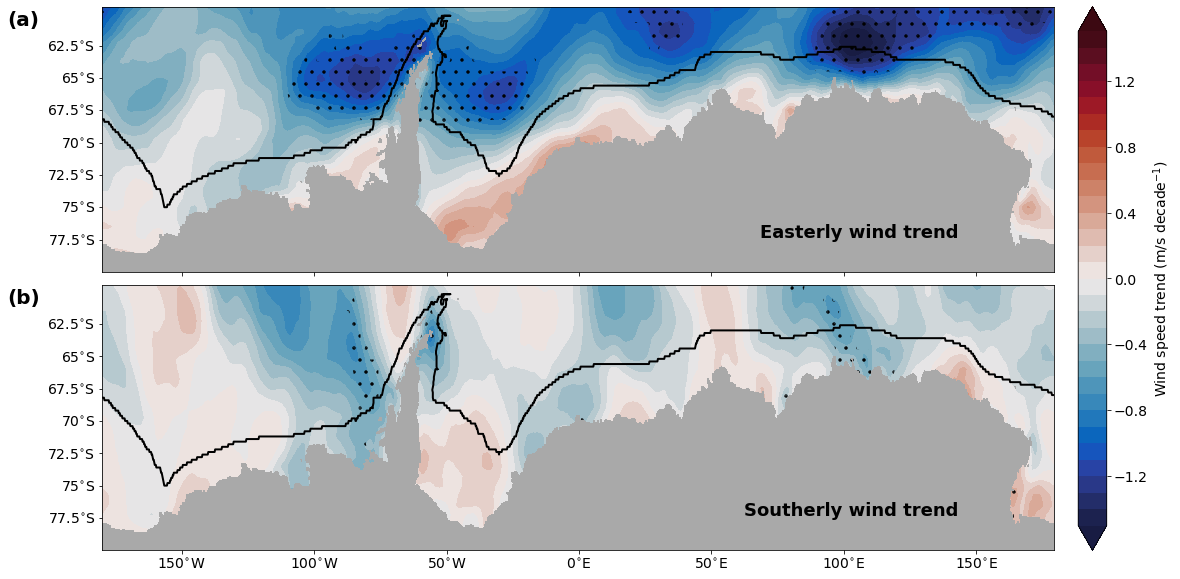

In [17]:
k = 'reanalysis'
fig, axs = figure2()
axs[0].text(0.9, .13, 'Easterly wind trend', horizontalalignment = 'right', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[1].text(0.9, .13, 'Southerly wind trend', horizontalalignment = 'right', transform = axs[1].transAxes, size = 18, weight = 'bold')

c = axs[0].contourf(uas_trends_DJF[k]['lon'], uas_trends_DJF[k]['lat'], -uas_trends_DJF[k]['trend']*10,
                   levels = np.arange(-1.5, 1.6, .1), extend = 'both', cmap = cmocean.cm.balance)
axs[0].contourf(uas_trends_DJF[k]['lon'], uas_trends_DJF[k]['lat'], uas_trends_DJF[k]['p'].where(uas_trends_DJF[k]['p'] <= .05),
                colors = ['none'], hatches = ['.'])

c = axs[1].contourf(vas_trends_DJF[k]['lon'], vas_trends_DJF[k]['lat'], vas_trends_DJF[k]['trend']*10,
                   levels = np.arange(-1.5, 1.6, .1), extend = 'both', cmap = cmocean.cm.balance)
axs[1].contourf(vas_trends_DJF[k]['lon'], vas_trends_DJF[k]['lat'], vas_trends_DJF[k]['p'].where(vas_trends_DJF[k]['p'] <= .05),
                colors = ['none'], hatches = ['.'])
fig.colorbar(c, cax = axs[-1]).set_label('Wind speed trend (m/s decade$^{-1}$)')
plt.savefig('../results/v6/trends-DJF-'+k+'-pre2000.jpg', bbox_inches = 'tight', dpi = 800)

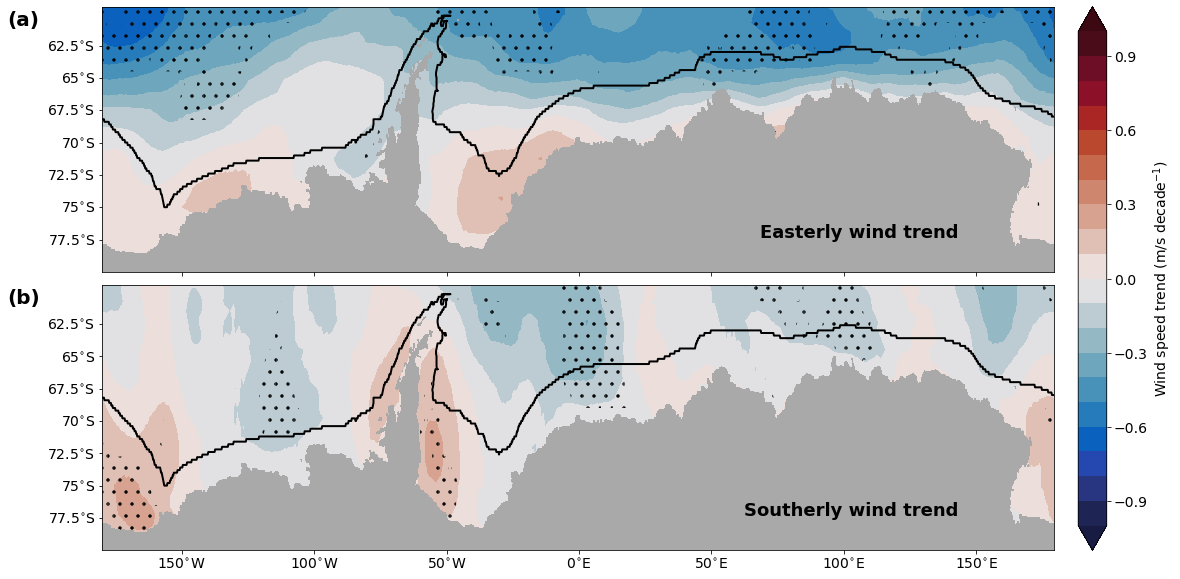

In [18]:
k = 'cmip6'
fig, axs = figure2()
axs[0].text(0.9, .13, 'Easterly wind trend', horizontalalignment = 'right', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[1].text(0.9, .13, 'Southerly wind trend', horizontalalignment = 'right', transform = axs[1].transAxes, size = 18, weight = 'bold')

c = axs[0].contourf(uas_trends_DJF[k]['lon'], uas_trends_DJF[k]['lat'], -uas_trends_DJF[k]['trend']*10,
                   levels = np.arange(-1, 1.1, .1), extend = 'both', cmap = cmocean.cm.balance)
axs[0].contourf(uas_trends_DJF[k]['lon'], uas_trends_DJF[k]['lat'], uas_trends_DJF[k]['p'].where(uas_trends_DJF[k]['p'] <= .05),
                colors = ['none'], hatches = ['.'])

c = axs[1].contourf(vas_trends_DJF[k]['lon'], vas_trends_DJF[k]['lat'], vas_trends_DJF[k]['trend']*10,
                   levels = np.arange(-1, 1.1, .1), extend = 'both', cmap = cmocean.cm.balance)
axs[1].contourf(vas_trends_DJF[k]['lon'], vas_trends_DJF[k]['lat'], vas_trends_DJF[k]['p'].where(vas_trends_DJF[k]['p'] <= .05),
                colors = ['none'], hatches = ['.'])
fig.colorbar(c, cax = axs[-1]).set_label('Wind speed trend (m/s decade$^{-1}$)')
plt.savefig('../results/v6/trends-DJF-'+k+'-pre2000.jpg', bbox_inches = 'tight', dpi = 800)

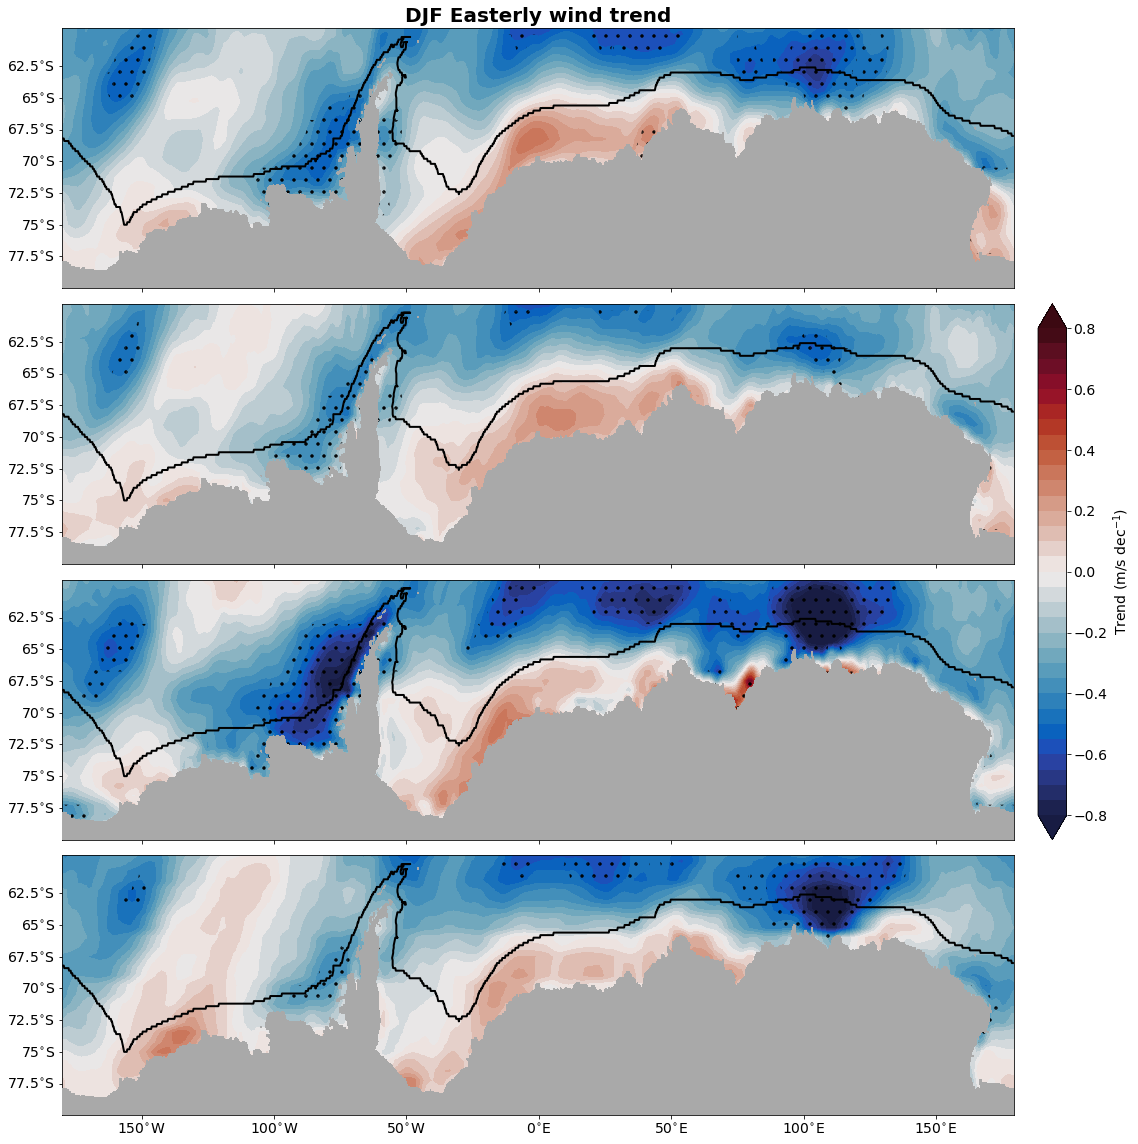

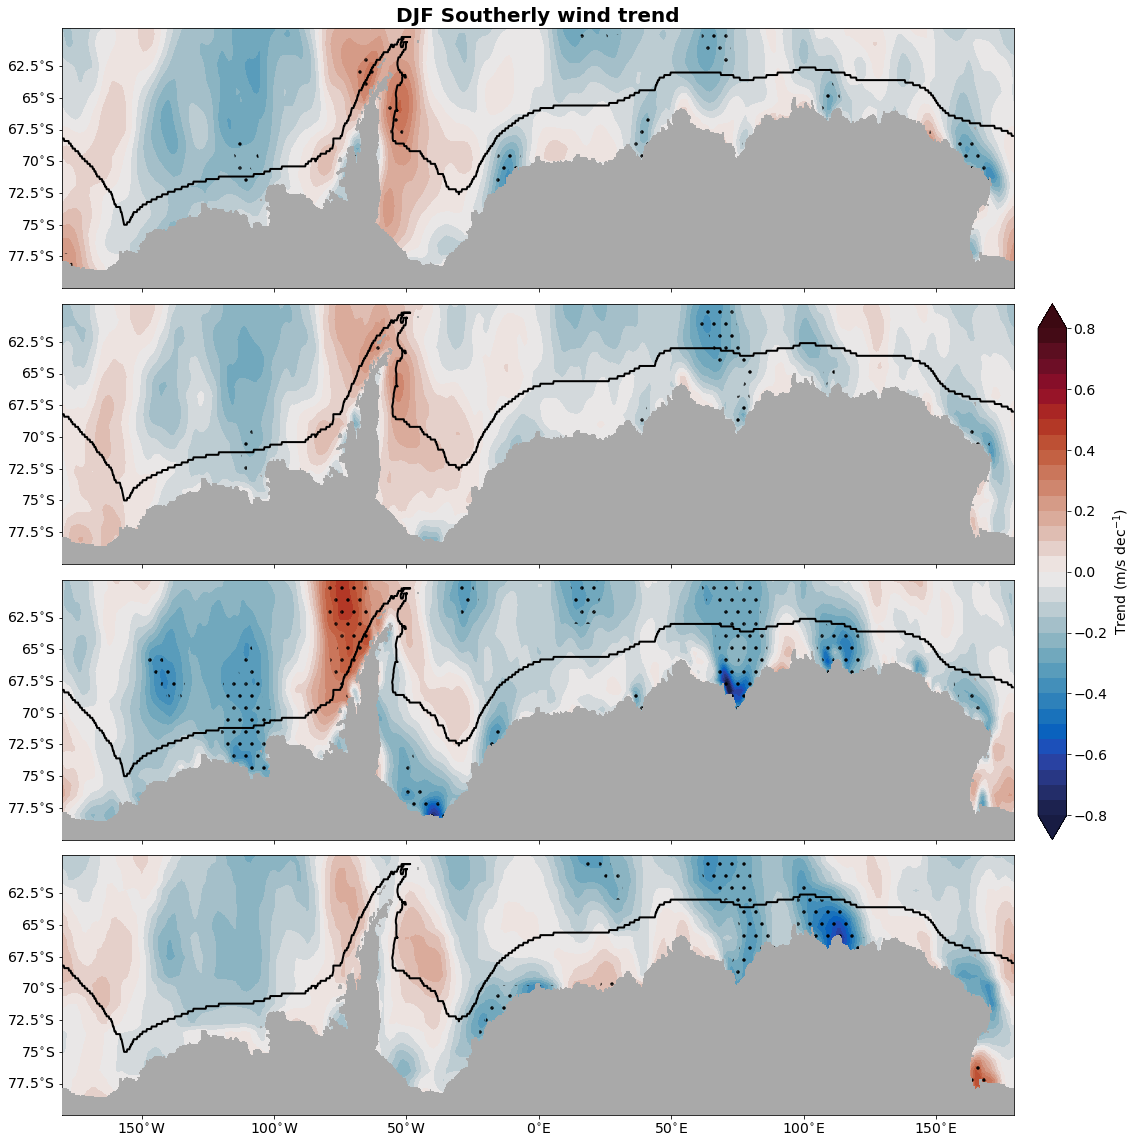

In [74]:
fig, axs = figure4()
axs[0].set_title('DJF Easterly wind trend', weight = 'bold', fontsize = 20)
n = 0
for k in keys[:-2]:
    c = axs[n].contourf(uas_trends_DJF[k]['lon'], uas_trends_DJF[k]['lat'], -uas_trends_DJF[k]['trend']*10,
                       levels = np.arange(-.8, .85, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(uas_trends_DJF[k]['lon'], uas_trends_DJF[k]['lat'], uas_trends_DJF[k]['p'].where(uas_trends_DJF[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Trend (m/s dec$^{-1}$)')
plt.savefig('../results/v6/uas-trends-DJF-ind_re.jpg', bbox_inches = 'tight')

fig, axs = figure4()
axs[0].set_title('DJF Southerly wind trend', weight = 'bold', fontsize = 20)
n = 0
for k in keys[:-2]:
    c = axs[n].contourf(vas_trends_DJF[k]['lon'], vas_trends_DJF[k]['lat'], vas_trends_DJF[k]['trend']*10,
                       levels = np.arange(-.8, .85, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(vas_trends_DJF[k]['lon'], vas_trends_DJF[k]['lat'], vas_trends_DJF[k]['p'].where(vas_trends_DJF[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Trend (m/s dec$^{-1}$)')
plt.savefig('../results/v6/vas-trends-DJF-ind_re.jpg', bbox_inches = 'tight')

# MAM

In [75]:
uas_trends_MAM = {}; vas_trends_MAM = {}
for k in keys:
    u = uas_MAM[k]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    uas_trends_MAM[k] = MK_class.compute()
    uas_trends_MAM[k] = uas_trends_MAM[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas_MAM[k]
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    vas_trends_MAM[k] = MK_class.compute()
    vas_trends_MAM[k] = vas_trends_MAM[k].rename({'x':'lon', 'y':'lat'})
    print(k)

erai
era5
cfsr
jra55
reanalysis
cmip6


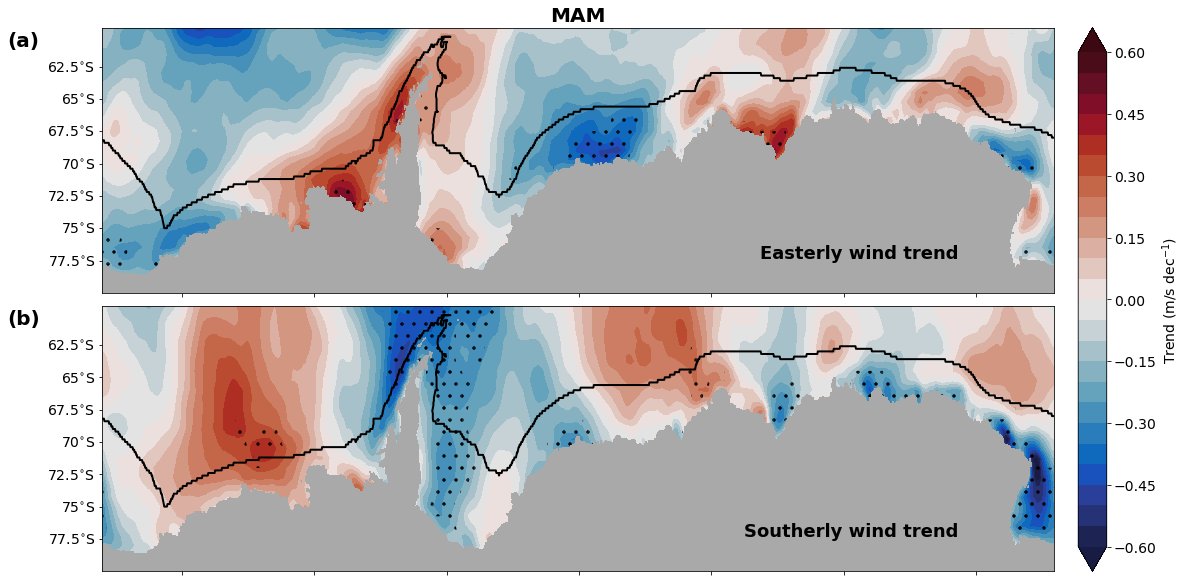

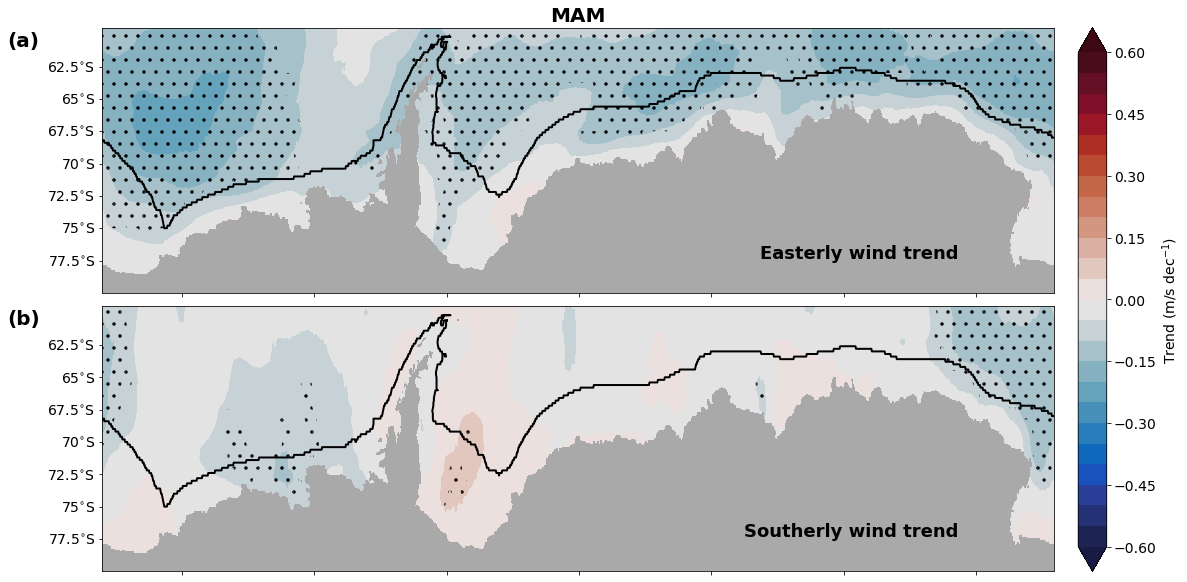

In [76]:
for k in ['reanalysis', 'cmip6']:
    fig, axs = figure2()
    axs[0].set_title('MAM', weight = 'bold', fontsize = 20)
    axs[0].text(0.9, .13, 'Easterly wind trend', horizontalalignment = 'right', transform = axs[0].transAxes, size = 18, weight = 'bold')
    axs[1].text(0.9, .13, 'Southerly wind trend', horizontalalignment = 'right', transform = axs[1].transAxes, size = 18, weight = 'bold')

    c = axs[0].contourf(uas_trends_MAM[k]['lon'], uas_trends_MAM[k]['lat'], -uas_trends_MAM[k]['trend']*10,
                       levels = np.arange(-.6, .65, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[0].contourf(uas_trends_MAM[k]['lon'], uas_trends_MAM[k]['lat'], uas_trends_MAM[k]['p'].where(uas_trends_MAM[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])

    c = axs[1].contourf(vas_trends_MAM[k]['lon'], vas_trends_MAM[k]['lat'], vas_trends_MAM[k]['trend']*10,
                       levels = np.arange(-.6, .65, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[1].contourf(vas_trends_MAM[k]['lon'], vas_trends_MAM[k]['lat'], vas_trends_MAM[k]['p'].where(vas_trends_MAM[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    fig.colorbar(c, cax = axs[-1]).set_label('Trend (m/s dec$^{-1}$)')
    plt.savefig('../results/v6/trends-MAM-'+k+'.jpg', bbox_inches = 'tight')

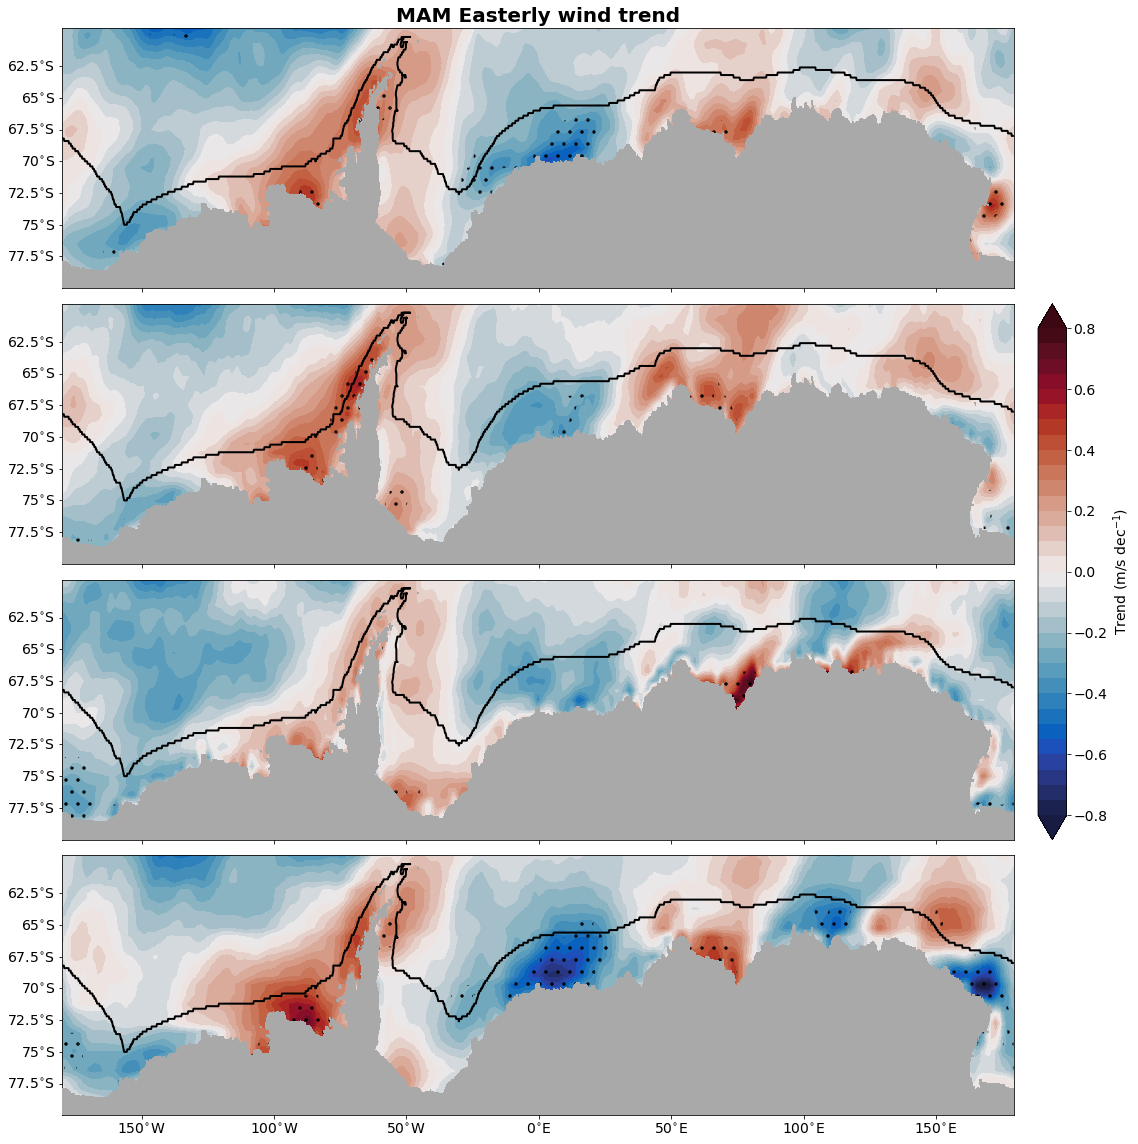

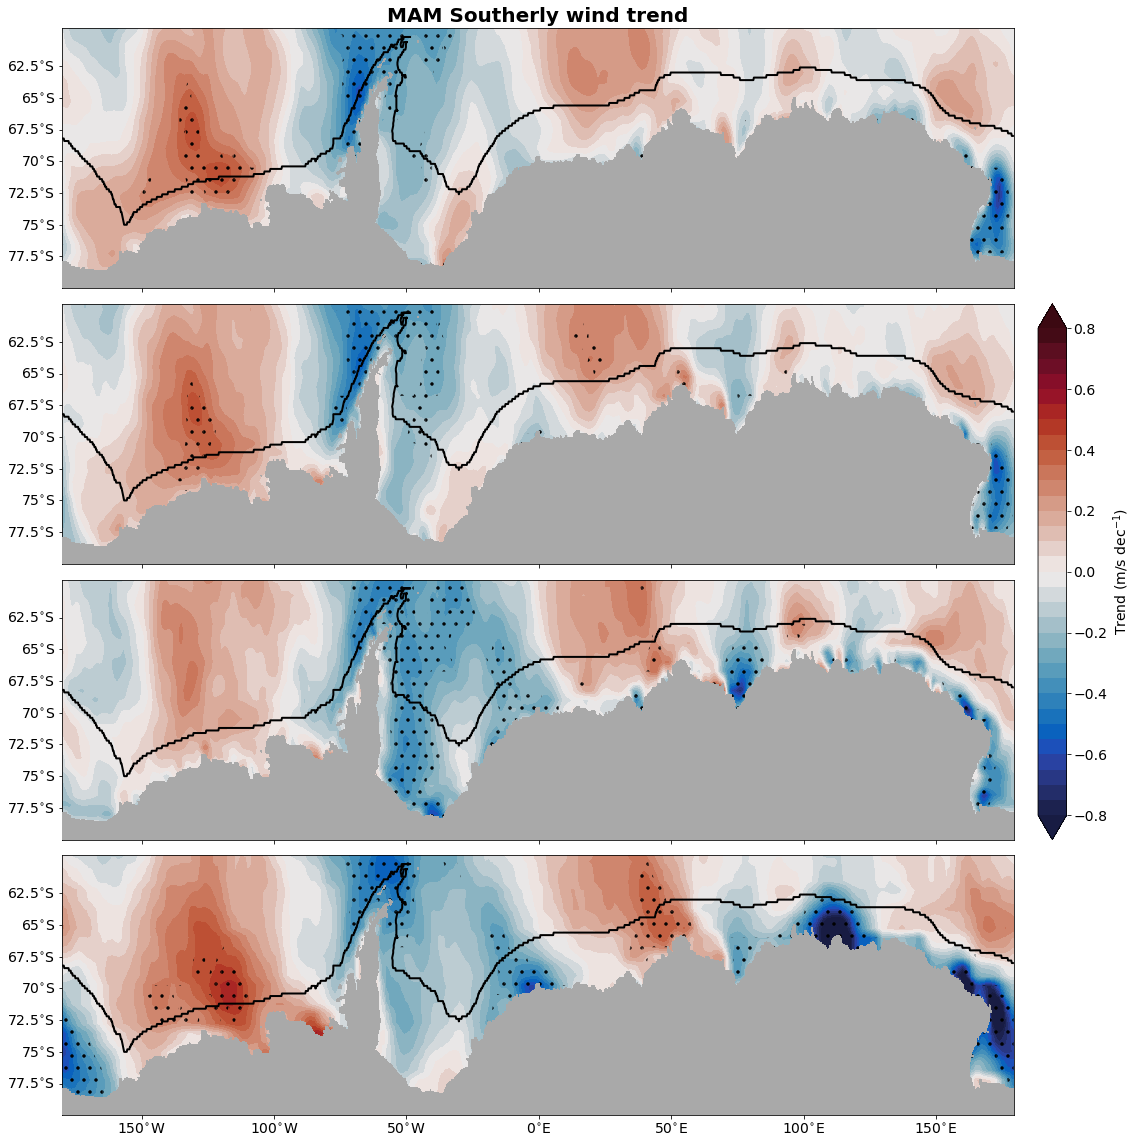

In [77]:
fig, axs = figure4()
axs[0].set_title('MAM Easterly wind trend', weight = 'bold', fontsize = 20)
n = 0
for k in keys[:-2]:
    c = axs[n].contourf(uas_trends_MAM[k]['lon'], uas_trends_MAM[k]['lat'], -uas_trends_MAM[k]['trend']*10,
                       levels = np.arange(-.8, .85, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(uas_trends_MAM[k]['lon'], uas_trends_MAM[k]['lat'], uas_trends_MAM[k]['p'].where(uas_trends_MAM[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Trend (m/s dec$^{-1}$)')
plt.savefig('../results/v6/uas-trends-MAM-ind_re.jpg', bbox_inches = 'tight')

fig, axs = figure4()
axs[0].set_title('MAM Southerly wind trend', weight = 'bold', fontsize = 20)
n = 0
for k in keys[:-2]:
    c = axs[n].contourf(vas_trends_MAM[k]['lon'], vas_trends_MAM[k]['lat'], vas_trends_MAM[k]['trend']*10,
                       levels = np.arange(-.8, .85, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(vas_trends_MAM[k]['lon'], vas_trends_MAM[k]['lat'], vas_trends_MAM[k]['p'].where(vas_trends_MAM[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Trend (m/s dec$^{-1}$)')
plt.savefig('../results/v6/vas-trends-MAM-ind_re.jpg', bbox_inches = 'tight')

# JJA

In [78]:
uas_trends_JJA = {}; vas_trends_JJA = {}
for k in keys:
    u = uas_JJA[k]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    uas_trends_JJA[k] = MK_class.compute()
    uas_trends_JJA[k] = uas_trends_JJA[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas_JJA[k]
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    vas_trends_JJA[k] = MK_class.compute()
    vas_trends_JJA[k] = vas_trends_JJA[k].rename({'x':'lon', 'y':'lat'})
    print(k)

erai
era5
cfsr
jra55
reanalysis
cmip6


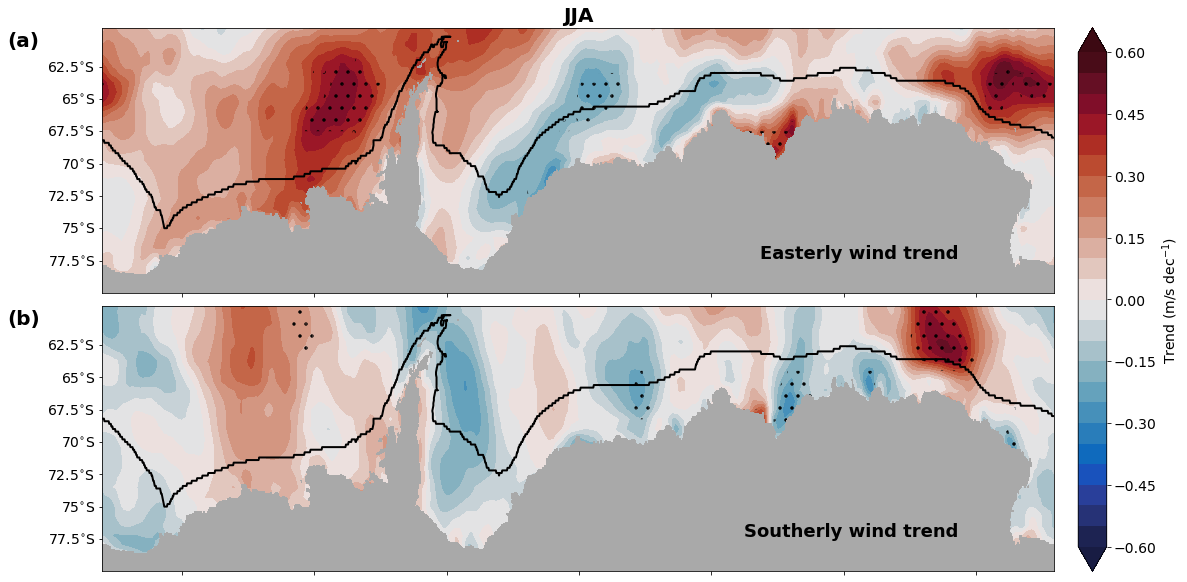

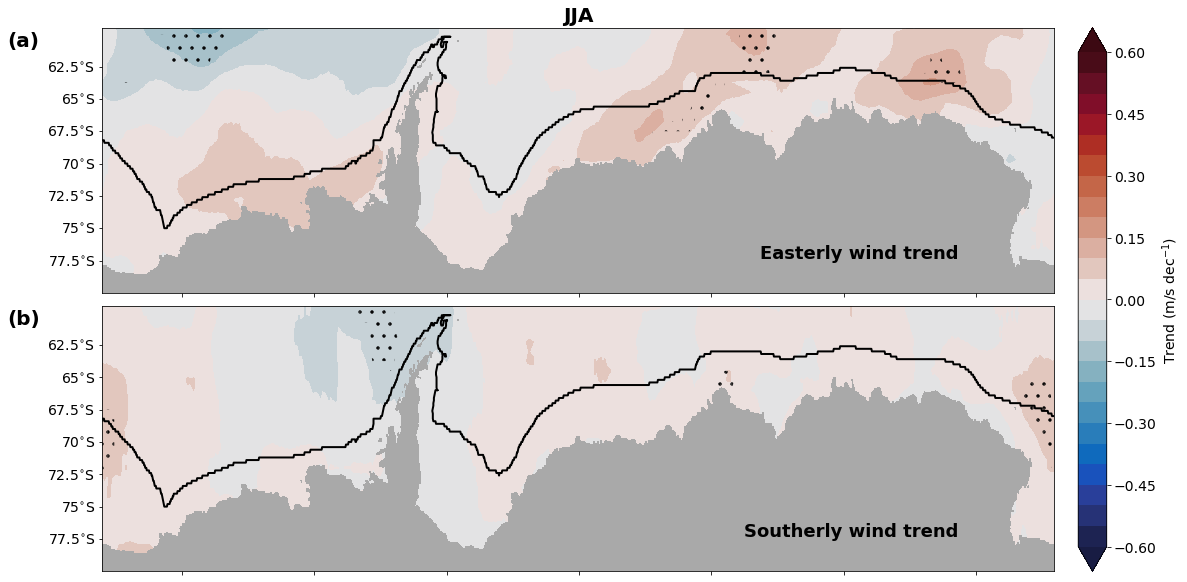

In [79]:
for k in ['reanalysis', 'cmip6']:
    fig, axs = figure2()
    axs[0].set_title('JJA', weight = 'bold', fontsize = 20)
    axs[0].text(0.9, .13, 'Easterly wind trend', horizontalalignment = 'right', transform = axs[0].transAxes, size = 18, weight = 'bold')
    axs[1].text(0.9, .13, 'Southerly wind trend', horizontalalignment = 'right', transform = axs[1].transAxes, size = 18, weight = 'bold')

    c = axs[0].contourf(uas_trends_JJA[k]['lon'], uas_trends_JJA[k]['lat'], -uas_trends_JJA[k]['trend']*10,
                       levels = np.arange(-.6, .65, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[0].contourf(uas_trends_JJA[k]['lon'], uas_trends_JJA[k]['lat'], uas_trends_JJA[k]['p'].where(uas_trends_JJA[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])

    c = axs[1].contourf(vas_trends_JJA[k]['lon'], vas_trends_JJA[k]['lat'], vas_trends_JJA[k]['trend']*10,
                       levels = np.arange(-.6, .65, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[1].contourf(vas_trends_JJA[k]['lon'], vas_trends_JJA[k]['lat'], vas_trends_JJA[k]['p'].where(vas_trends_JJA[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    fig.colorbar(c, cax = axs[-1]).set_label('Trend (m/s dec$^{-1}$)')
    plt.savefig('../results/v6/trends-JJA-'+k+'.jpg', bbox_inches = 'tight')

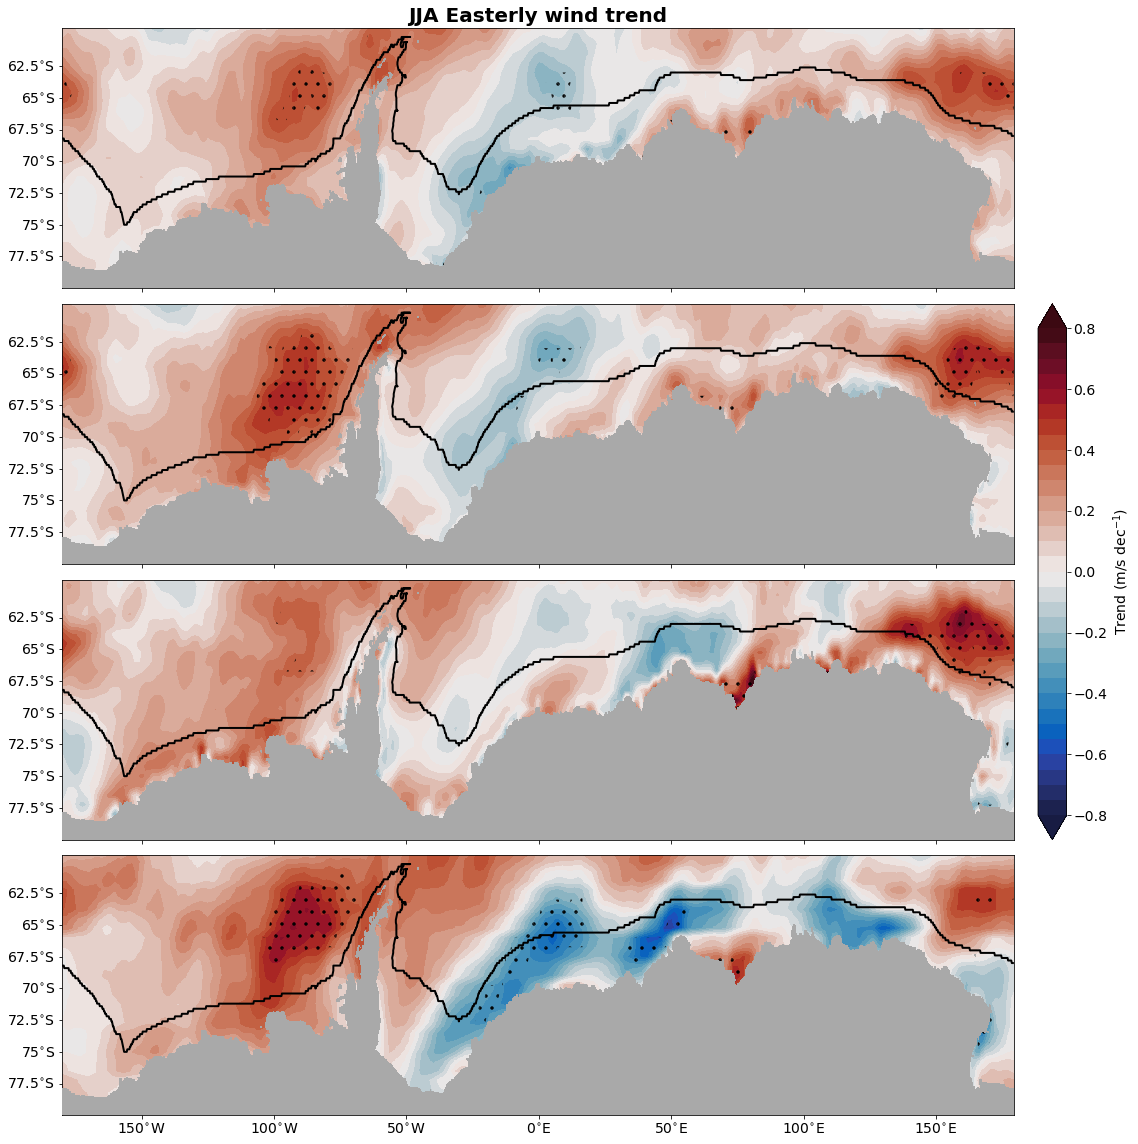

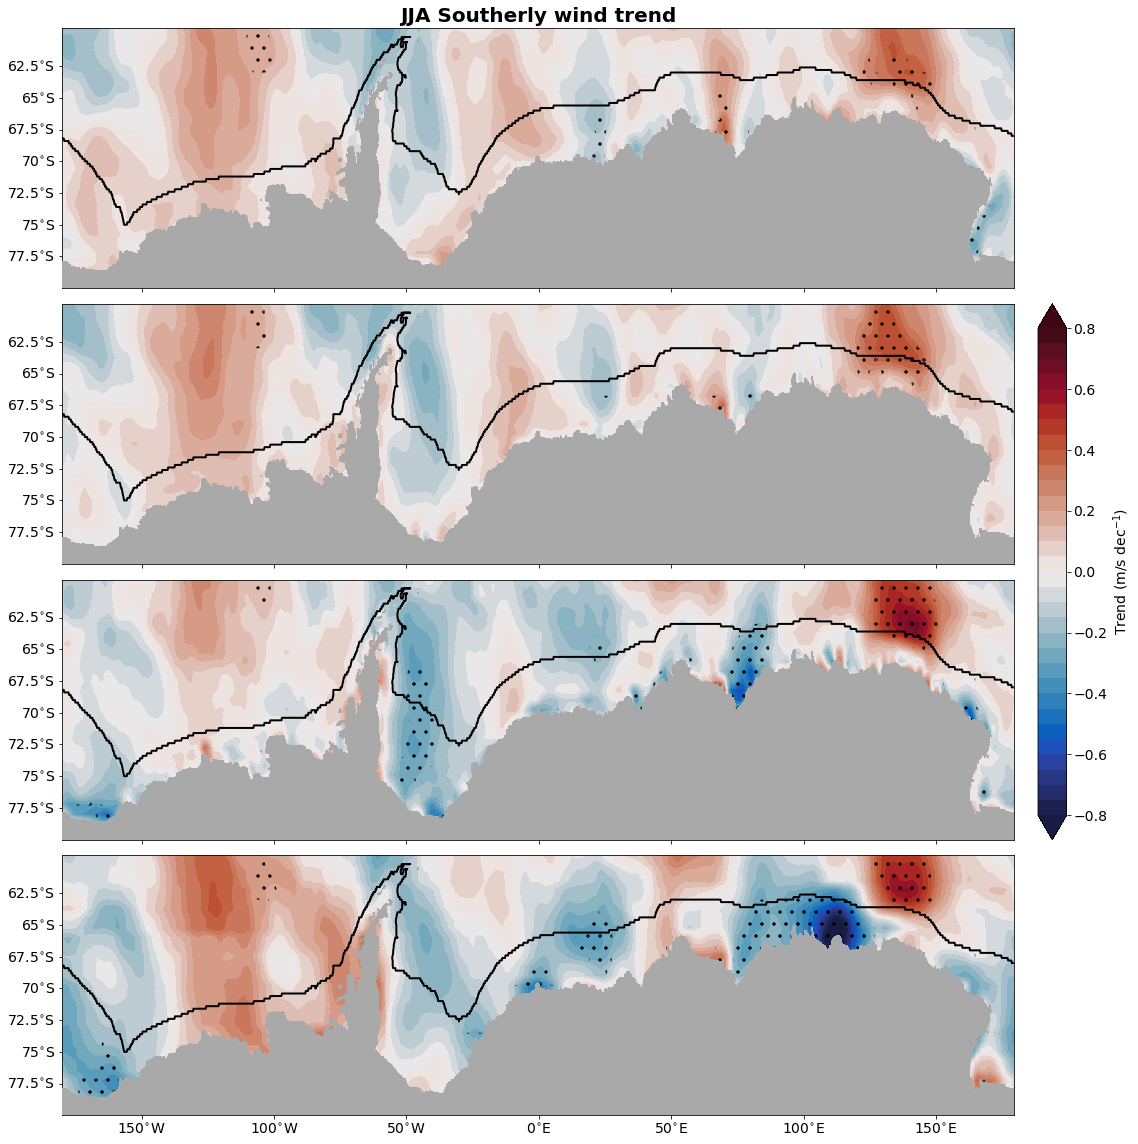

In [80]:
fig, axs = figure4()
axs[0].set_title('JJA Easterly wind trend', weight = 'bold', fontsize = 20)
n = 0
for k in keys[:-2]:
    c = axs[n].contourf(uas_trends_JJA[k]['lon'], uas_trends_JJA[k]['lat'], -uas_trends_JJA[k]['trend']*10,
                       levels = np.arange(-.8, .85, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(uas_trends_JJA[k]['lon'], uas_trends_JJA[k]['lat'], uas_trends_JJA[k]['p'].where(uas_trends_JJA[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Trend (m/s dec$^{-1}$)')
plt.savefig('../results/v6/uas-trends-JJA-ind_re.jpg', bbox_inches = 'tight')

fig, axs = figure4()
axs[0].set_title('JJA Southerly wind trend', weight = 'bold', fontsize = 20)
n = 0
for k in keys[:-2]:
    c = axs[n].contourf(vas_trends_JJA[k]['lon'], vas_trends_JJA[k]['lat'], vas_trends_JJA[k]['trend']*10,
                       levels = np.arange(-.8, .85, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(vas_trends_JJA[k]['lon'], vas_trends_JJA[k]['lat'], vas_trends_JJA[k]['p'].where(vas_trends_JJA[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Trend (m/s dec$^{-1}$)')
plt.savefig('../results/v6/vas-trends-JJA-ind_re.jpg', bbox_inches = 'tight')

# SON

In [81]:
uas_trends_SON = {}; vas_trends_SON = {}
for k in keys:
    u = uas_SON[k]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    uas_trends_SON[k] = MK_class.compute()
    uas_trends_SON[k] = uas_trends_SON[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas_SON[k]
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    vas_trends_SON[k] = MK_class.compute()
    vas_trends_SON[k] = vas_trends_SON[k].rename({'x':'lon', 'y':'lat'})
    print(k)

erai
era5
cfsr
jra55
reanalysis
cmip6


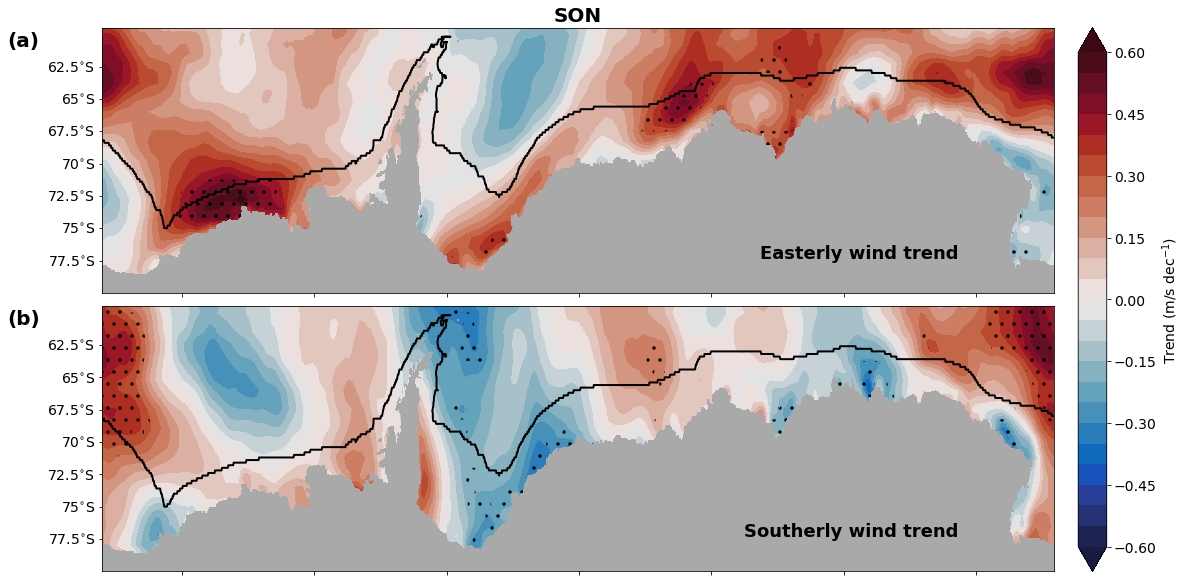

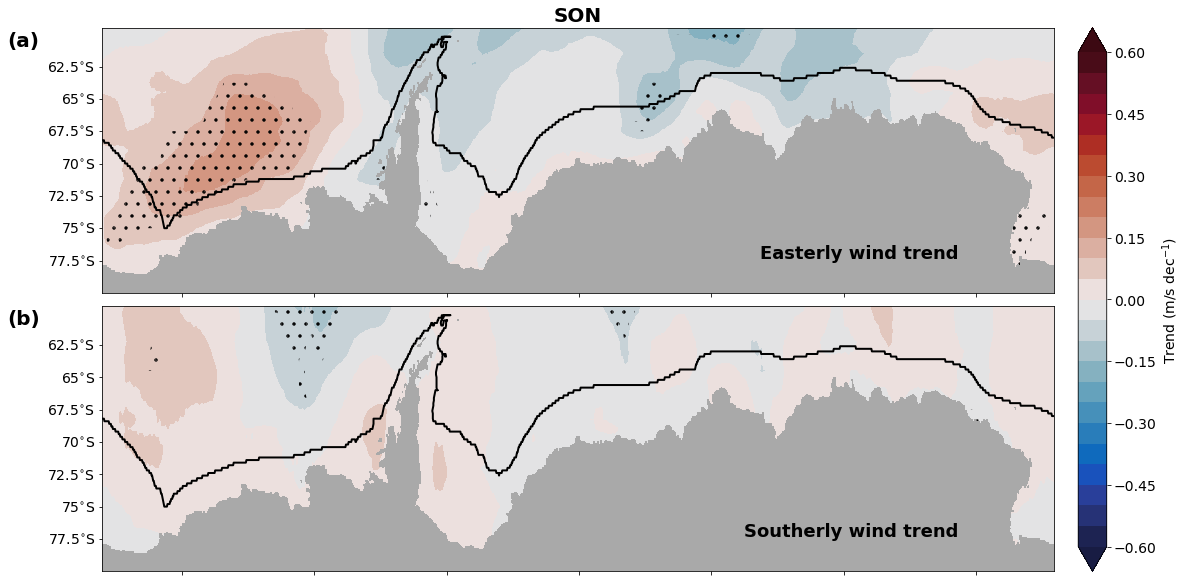

In [82]:
for k in ['reanalysis', 'cmip6']:
    fig, axs = figure2()
    axs[0].set_title('SON', weight = 'bold', fontsize = 20)
    axs[0].text(0.9, .13, 'Easterly wind trend', horizontalalignment = 'right', transform = axs[0].transAxes, size = 18, weight = 'bold')
    axs[1].text(0.9, .13, 'Southerly wind trend', horizontalalignment = 'right', transform = axs[1].transAxes, size = 18, weight = 'bold')

    c = axs[0].contourf(uas_trends_SON[k]['lon'], uas_trends_SON[k]['lat'], -uas_trends_SON[k]['trend']*10,
                       levels = np.arange(-.6, .65, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[0].contourf(uas_trends_SON[k]['lon'], uas_trends_SON[k]['lat'], uas_trends_SON[k]['p'].where(uas_trends_SON[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])

    c = axs[1].contourf(vas_trends_SON[k]['lon'], vas_trends_SON[k]['lat'], vas_trends_SON[k]['trend']*10,
                       levels = np.arange(-.6, .65, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[1].contourf(vas_trends_SON[k]['lon'], vas_trends_SON[k]['lat'], vas_trends_SON[k]['p'].where(vas_trends_SON[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    fig.colorbar(c, cax = axs[-1]).set_label('Trend (m/s dec$^{-1}$)')
    plt.savefig('../results/v6/trends-SON-'+k+'.jpg', bbox_inches = 'tight')

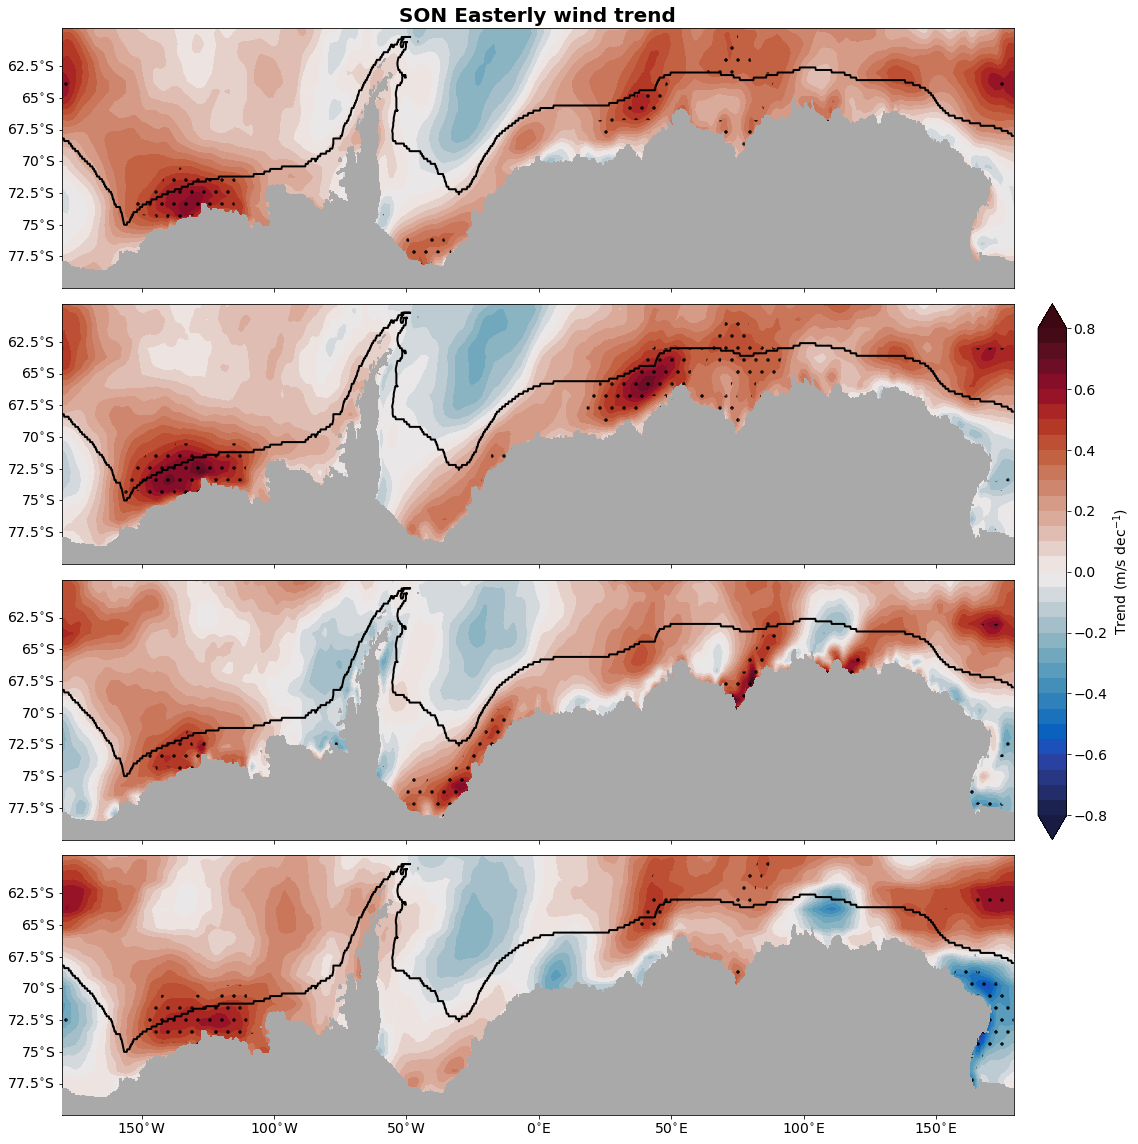

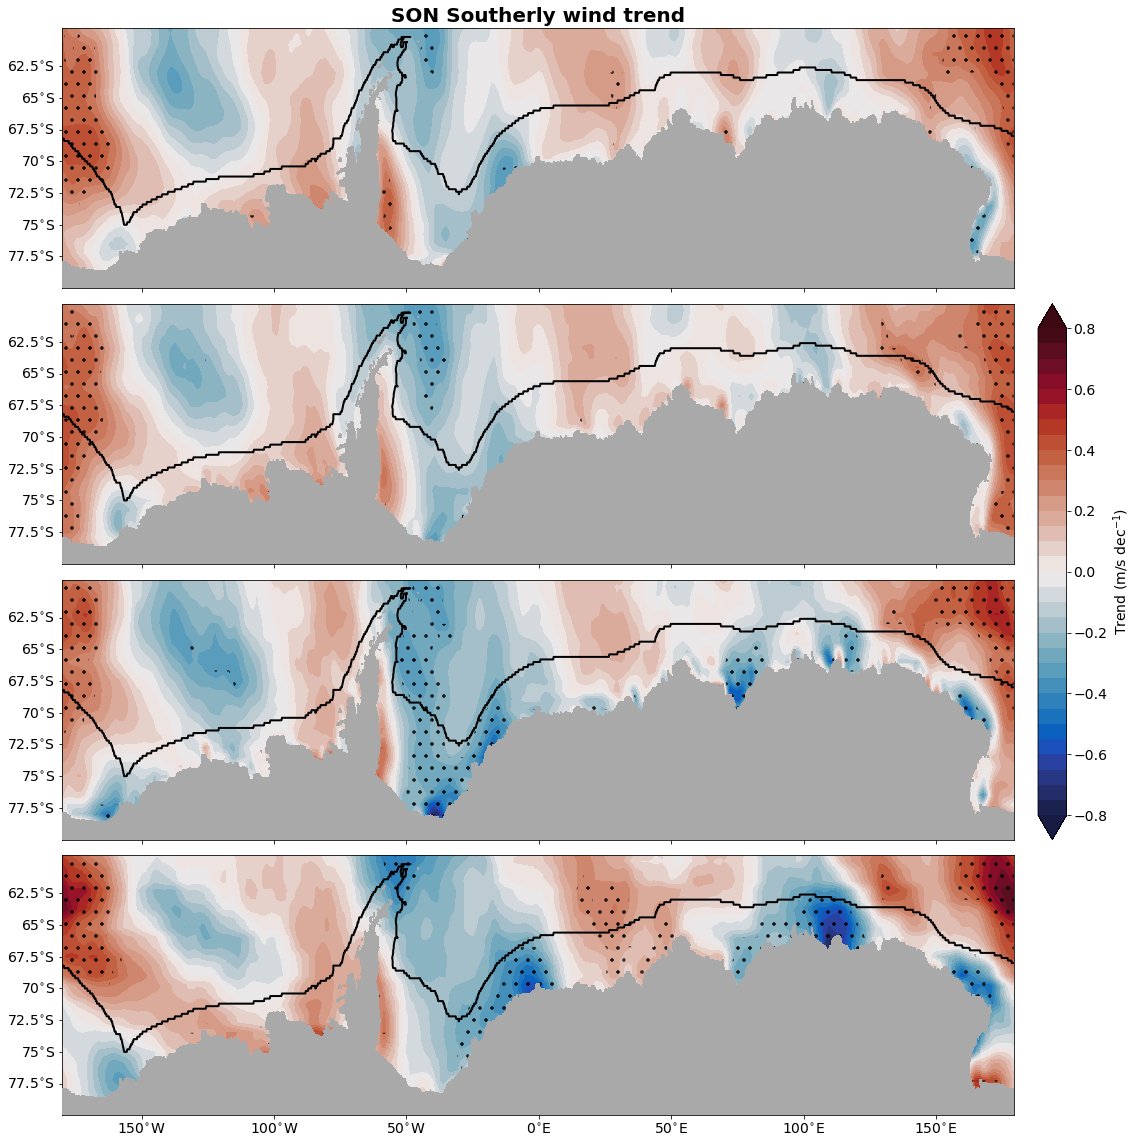

In [83]:
fig, axs = figure4()
axs[0].set_title('SON Easterly wind trend', weight = 'bold', fontsize = 20)
n = 0
for k in keys[:-2]:
    c = axs[n].contourf(uas_trends_SON[k]['lon'], uas_trends_SON[k]['lat'], -uas_trends_SON[k]['trend']*10,
                       levels = np.arange(-.8, .85, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(uas_trends_SON[k]['lon'], uas_trends_SON[k]['lat'], uas_trends_SON[k]['p'].where(uas_trends_SON[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Trend (m/s dec$^{-1}$)')
plt.savefig('../results/v6/uas-trends-SON-ind_re.jpg', bbox_inches = 'tight')

fig, axs = figure4()
axs[0].set_title('SON Southerly wind trend', weight = 'bold', fontsize = 20)
n = 0
for k in keys[:-2]:
    c = axs[n].contourf(vas_trends_SON[k]['lon'], vas_trends_SON[k]['lat'], vas_trends_SON[k]['trend']*10,
                       levels = np.arange(-.8, .85, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(vas_trends_SON[k]['lon'], vas_trends_SON[k]['lat'], vas_trends_SON[k]['p'].where(vas_trends_SON[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Trend (m/s dec$^{-1}$)')
plt.savefig('../results/v6/vas-trends-SON-ind_re.jpg', bbox_inches = 'tight')

# DJF pre 2000s

In [6]:
uas = {}
vas = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('1979-01-01', '2000-01-01'))
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('1979-01-01', '2000-01-01'))

In [7]:
uas_DJF = {}
vas_DJF = {}
for k in keys:
    uas_DJF[k] = uas[k].where(uas[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    vas_DJF[k] = vas[k].where(vas[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()

In [8]:
uas_trends_DJF = {}; vas_trends_DJF = {}
for k in keys:
    u = uas_DJF[k]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    uas_trends_DJF[k] = MK_class.compute()
    uas_trends_DJF[k] = uas_trends_DJF[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas_DJF[k]
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    vas_trends_DJF[k] = MK_class.compute()
    vas_trends_DJF[k] = vas_trends_DJF[k].rename({'x':'lon', 'y':'lat'})
    print(k)

erai
era5
cfsr
jra55
reanalysis
cmip6


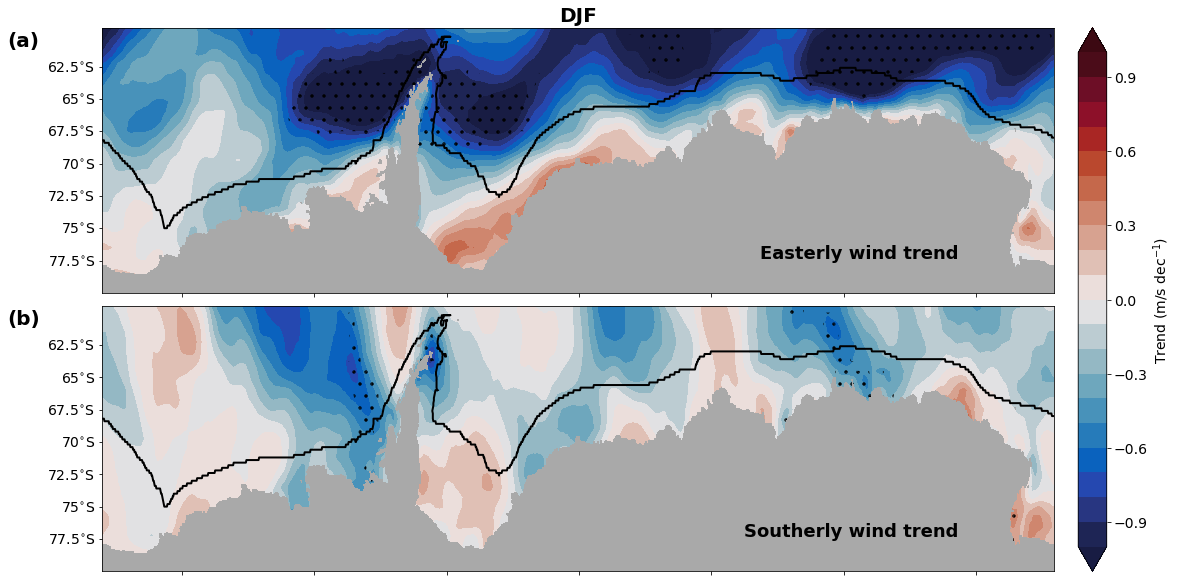

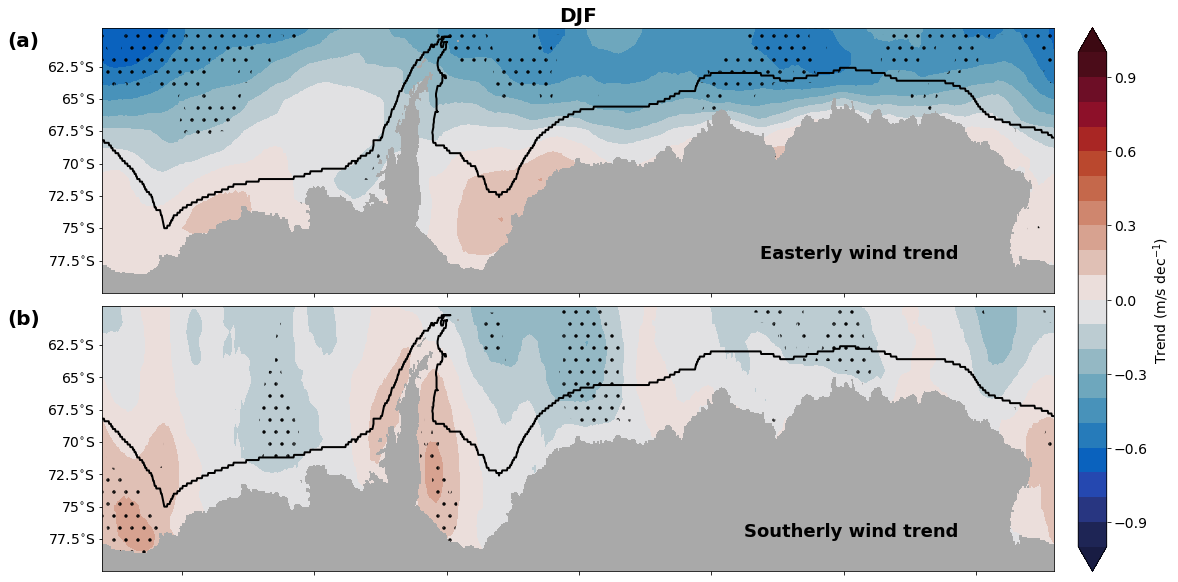

In [10]:
for k in ['reanalysis', 'cmip6']:
    fig, axs = figure2()
    axs[0].set_title('DJF', weight = 'bold', fontsize = 20)
    axs[0].text(0.9, .13, 'Easterly wind trend', horizontalalignment = 'right', transform = axs[0].transAxes, size = 18, weight = 'bold')
    axs[1].text(0.9, .13, 'Southerly wind trend', horizontalalignment = 'right', transform = axs[1].transAxes, size = 18, weight = 'bold')

    c = axs[0].contourf(uas_trends_DJF[k]['lon'], uas_trends_DJF[k]['lat'], -uas_trends_DJF[k]['trend']*10,
                       levels = np.arange(-1, 1.1, .1), extend = 'both', cmap = cmocean.cm.balance)
    axs[0].contourf(uas_trends_DJF[k]['lon'], uas_trends_DJF[k]['lat'], uas_trends_DJF[k]['p'].where(uas_trends_DJF[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])

    c = axs[1].contourf(vas_trends_DJF[k]['lon'], vas_trends_DJF[k]['lat'], vas_trends_DJF[k]['trend']*10,
                       levels = np.arange(-1, 1.1, .1), extend = 'both', cmap = cmocean.cm.balance)
    axs[1].contourf(vas_trends_DJF[k]['lon'], vas_trends_DJF[k]['lat'], vas_trends_DJF[k]['p'].where(vas_trends_DJF[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    fig.colorbar(c, cax = axs[-1]).set_label('Trend (m/s dec$^{-1}$)')
    #plt.savefig('../results/v6/trends-DJF-'+k+'.jpg', bbox_inches = 'tight')